# 학습된 모델 저장

- 학습이 완료된 모델을 파일로 저장하여, 이후 추가 학습이나 예측 서비스에 사용할 수 있도록 한다.
- 파이토치(PyTorch)는 **모델의 파라미터만 저장**하는 방법과 **모델의 구조와 파라미터를 모두 저장**하는 두 가지 방식을 제공한다.
- 저장 함수
  - `torch.save(저장할 객체, 저장 경로)`
- 보통 저장 파일의 확장자는 `.pt`나 `.pth`를 사용한다.

## 모델 전체 저장 및 불러오기

- 저장하기
  - `torch.save(model, 저장 경로)`
- 불러오기
  - `load_model = torch.load(저장 경로)`
- 모델 저장 시 **피클(pickle)**을 사용해 직렬화되므로, 모델을 불러오는 실행 환경에도 저장할 때 사용한 클래스 정의가 필요하다.


## 모델의 파라미터만 저장

-   모델을 구성하는 파라미터만 저장한다.
-   모델의 구조는 저장하지 않기 때문에 불러올 때 **모델을 먼저 생성하고 생성한 모델에 불러온 파라미터를 덮어씌운다.**
-   모델의 파라미터는 **state_dict** 형식으로 저장한다.

### state_dict

-   모델의 파라미터 Tensor들을 레이어 단위별로 나누어 저장한 Ordered Dictionary (OrderedDict)
-   `모델객체.state_dict()` 메소드를 이용해 조회한다.
-   모델의 state_dict을 조회 후 저장한다.
    -   `torch.save(model.state_dict(), "저장경로")`
-   생성된 모델에 읽어온 state_dict를 덮어씌운다.
    -   `new_model.load_state_dict(torch.load("state_dict저장경로"))`


## 모델의 파라미터만 저장

- 모델을 구성하는 **파라미터만 저장**하는 방법이다.
- 모델의 구조는 저장되지 않기 때문에, 불러올 때는 **동일한 모델 구조를 먼저 생성하고**, 생성한 모델에 불러온 파라미터를 적용해야 한다.
- 모델의 파라미터는 **state_dict** 형태로 저장된다.

### state_dict

- state_dict은 모델의 파라미터 텐서(Tensor)들을 레이어 단위로 구분해 저장하는 **OrderedDict** 객체이다.
- `모델객체.state_dict()` 메서드를 사용하여 조회할 수 있다.
- 모델의 state_dict을 조회하여 저장한다.
  - `torch.save(model.state_dict(), "저장경로")`
- 생성한 모델에 저장된 state_dict을 읽어 적용한다.
  - `new_model.load_state_dict(torch.load("state_dict저장경로"))`

## Checkpoint 저장 및 불러오기

- 학습이 끝나지 않은 모델을 저장하고, 나중에 이어서 학습시키려면 모델의 구조와 파라미터뿐만 아니라 optimizer, loss 함수 등 학습에 필요한 객체들도 함께 저장해야 한다.
- 딕셔너리(Dictionary)에 저장하려는 값들을 key-value 쌍으로 구성하여 `torch.save()`를 이용해 저장한다.

```python
# 저장
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss
}, "저장경로")

# 불러오기
model = MyModel()
optimizer = optim.Adam(model.parameters())

# 불러온 checkpoint를 이용해 이전 학습 상태 복원
checkpoint = torch.load("저장경로")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
```

>`nn.Module`은 PyTorch에서 딥러닝 모델을 만들기 위한 모든 클래스의 부모이며,<br>
>모델의 구조, 파라미터, 학습 관련 기능을 모두 포함하고 관리하는 기반 클래스입니다.

필요하면 `nn.Module` 없이도 만들 수는 있지만, 학습과 저장/불러오기 기능을 쓰려면 반드시 상속받아야 한다.

In [32]:
# 간단한 모델 정의
import torch
import torch.nn as nn

class MyModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(3, 4) # 파라미터의 개수 = 3 X 4 + 4  weight : Input 개수 *Output 개수  bias : output 개수
        self.lr2 = nn.Linear(4, 2) # 파라미터의 개수 = 4 X 2 + 2
        self.relu = nn.ReLU() # activation함수->파라미터가 없는 단순 계산함수. relu(X) = max(X, 0)
    def forward(self, X):
        X = self.lr1(X)
        X = self.relu(X)
        X = self.lr2(X)
        return X

### 선형 회귀: 수학 vs PyTorch의 행렬곱 차이

#### 수학적 이론
- 수식:  ŷ = W · X + b
- 입력 X: (n × 1) column vector
- 가중치 W: (1 × n) row vector
- 곱셈 순서: W · X
- 결과: (1 × 1) 스칼라

#### PyTorch에서의 계산
- nn.Linear(in_features=n, out_features=m)
- 입력 X: (batch_size × n)
- weight W: (m × n)
- 연산: output = X @ W.T + b
- 결과: (batch_size × m)

#### 핵심 차이
- 수학에서는 W · X 형태 사용
- PyTorch에서는 입력이 앞에 오므로 X @ W.T 형태 사용
- 행렬곱은 교환법칙이 성립하지 않음 → 순서 바꾸면 계산 불가능하거나 의미가 달라짐


In [33]:
# 모델 생성
model = MyModel()
model

MyModel(
  (lr1): Linear(in_features=3, out_features=4, bias=True)
  (lr2): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

In [ ]:
# 레이어의 파라미터를 조회
# 모델에서 레이어객체를 조회
## model의 lr1을 "lr1"이라는 변수에 정의해준다.
## lr1을 먼저 정의해주어야 이후에 lr1에 .weight와 같은 메서드를 붙여 정보를 조회할 수 있다.
lr1 = model.lr1
lr1

Linear(in_features=3, out_features=4, bias=True)

In [35]:
# 레이어에서  weight/bias 조회
w = lr1.weight
print(w.shape)
w

torch.Size([4, 3])


Parameter containing:
tensor([[ 0.5488,  0.4978,  0.3722],
        [ 0.0234,  0.2672,  0.2216],
        [ 0.4125,  0.0911,  0.0718],
        [-0.4488, -0.1723, -0.2624]], requires_grad=True)

In [36]:
b = lr1.bias
print(b.shape)
b

torch.Size([4])


Parameter containing:
tensor([-0.3398,  0.2838, -0.2419, -0.1387], requires_grad=True)

In [37]:
lr2 = model.lr2

In [38]:
import os
os.makedirs("saved_models", exist_ok=True)

In [39]:
################################################
#  모델을 저장
################################################
torch.save(model, "saved_models/my_model.pt")

In [40]:
################################################
#  저장된 모델 Load
################################################
load_model = torch.load("saved_models/my_model.pt", weights_only=False) #모델만 저장했기 때문에 false로 주어야 읽어올 수 있음.

In [41]:
load_model

MyModel(
  (lr1): Linear(in_features=3, out_features=4, bias=True)
  (lr2): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

In [42]:
load_lr1 = load_model.lr1
load_lr2 = load_model.lr2
print(lr1.weight)
print(load_lr1.weight)
print(lr1.bias)
print(load_lr1.bias)

print("\n","="*50,"\n")

print(lr2.weight)
print(load_lr2.weight)
print(lr2.bias)
print(load_lr2.bias)

Parameter containing:
tensor([[ 0.5488,  0.4978,  0.3722],
        [ 0.0234,  0.2672,  0.2216],
        [ 0.4125,  0.0911,  0.0718],
        [-0.4488, -0.1723, -0.2624]], requires_grad=True)
Parameter containing:
tensor([[ 0.5488,  0.4978,  0.3722],
        [ 0.0234,  0.2672,  0.2216],
        [ 0.4125,  0.0911,  0.0718],
        [-0.4488, -0.1723, -0.2624]], requires_grad=True)
Parameter containing:
tensor([-0.3398,  0.2838, -0.2419, -0.1387], requires_grad=True)
Parameter containing:
tensor([-0.3398,  0.2838, -0.2419, -0.1387], requires_grad=True)


Parameter containing:
tensor([[-0.3108, -0.2417, -0.2140,  0.2940],
        [-0.0802,  0.0044, -0.1355, -0.2434]], requires_grad=True)
Parameter containing:
tensor([[-0.3108, -0.2417, -0.2140,  0.2940],
        [-0.0802,  0.0044, -0.1355, -0.2434]], requires_grad=True)
Parameter containing:
tensor([-0.2969, -0.0365], requires_grad=True)
Parameter containing:
tensor([-0.2969, -0.0365], requires_grad=True)


In [43]:
print(lr1.weight == load_lr1.weight)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])


In [44]:
################################################
#  모델에 Layer들을 조회. 모델.instance변수명
################################################
lr_layer = model.lr1
lr_layer

Linear(in_features=3, out_features=4, bias=True)

In [45]:
################################################
#  Layer의 파라미터(weight/bias) 조회
################################################
lr1_weight = lr_layer.weight
lr1_bias = lr_layer.bias

In [46]:
lr1_weight

Parameter containing:
tensor([[ 0.5488,  0.4978,  0.3722],
        [ 0.0234,  0.2672,  0.2216],
        [ 0.4125,  0.0911,  0.0718],
        [-0.4488, -0.1723, -0.2624]], requires_grad=True)

In [47]:
lr1_bias

Parameter containing:
tensor([-0.3398,  0.2838, -0.2419, -0.1387], requires_grad=True)

In [48]:
######################################################
# 모델의 파라미터들(weight들, bias들)만 저장/불러오기 >> state_dict : w와b가 dict 형태로 저장된 것
######################################################
state_dict = model.state_dict()
state_dict

OrderedDict([('lr1.weight',
              tensor([[ 0.5488,  0.4978,  0.3722],
                      [ 0.0234,  0.2672,  0.2216],
                      [ 0.4125,  0.0911,  0.0718],
                      [-0.4488, -0.1723, -0.2624]])),
             ('lr1.bias', tensor([-0.3398,  0.2838, -0.2419, -0.1387])),
             ('lr2.weight',
              tensor([[-0.3108, -0.2417, -0.2140,  0.2940],
                      [-0.0802,  0.0044, -0.1355, -0.2434]])),
             ('lr2.bias', tensor([-0.2969, -0.0365]))])

In [49]:
state_dict.keys()

odict_keys(['lr1.weight', 'lr1.bias', 'lr2.weight', 'lr2.bias'])

In [50]:
###################
# state_dict 저장
###################

torch.save(state_dict, "saved_models/my_model_parameter.pt")

In [57]:
#####################
# state_dict load
#####################
sd = torch.load("saved_models/my_model_parameter.pt")
sd

OrderedDict([('lr1.weight',
              tensor([[ 0.5488,  0.4978,  0.3722],
                      [ 0.0234,  0.2672,  0.2216],
                      [ 0.4125,  0.0911,  0.0718],
                      [-0.4488, -0.1723, -0.2624]])),
             ('lr1.bias', tensor([-0.3398,  0.2838, -0.2419, -0.1387])),
             ('lr2.weight',
              tensor([[-0.3108, -0.2417, -0.2140,  0.2940],
                      [-0.0802,  0.0044, -0.1355, -0.2434]])),
             ('lr2.bias', tensor([-0.2969, -0.0365]))])

In [ ]:
# load한 state_dict를 모델 파라미터에 적용(덮어 씌운다.)

## model1이나 new_model이라 같은 MyModel()에 의해서 같은 파라미터 아닌가?
## 아닙니다. MyModel()클래스를 이용해서 모델을 새롭게 만들때마다(새롭게 변수에 담을 때 마다) 무작위의 새로운 모델이 생성
## 따라서 model1의 학습된 파라미터를 model2에 복사하고 싶을때 지금과 같은 과정을 사용하는 것.
## 현재 new_model은 학습이 안되어 무작위의 파라미터를 가진 상태
## 따라서 위에서 호출된 sd와 파라미터가 다른걸 알 수 있다.
## 본 cell을 계속 실행해보면 new_model의 파라미터를 계속 무작위로 바뀐다.

new_model = MyModel()
new_model.state_dict() # 덮어씌우기전 new_model의 파라미터 확인

OrderedDict([('lr1.weight',
              tensor([[ 0.3547,  0.3763,  0.0579],
                      [-0.0226,  0.4621, -0.3894],
                      [-0.3266,  0.3915, -0.3248],
                      [ 0.2461, -0.1497,  0.3379]])),
             ('lr1.bias', tensor([-0.3354,  0.2562, -0.3674,  0.5009])),
             ('lr2.weight',
              tensor([[-0.2688,  0.2200, -0.4685, -0.0007],
                      [ 0.0322, -0.4542,  0.2033,  0.0722]])),
             ('lr2.bias', tensor([0.0352, 0.2692]))])

In [ ]:
sd # 덮어씌울 파라미터정보 담긴 sd 파라미터 확인

OrderedDict([('lr1.weight',
              tensor([[ 0.5488,  0.4978,  0.3722],
                      [ 0.0234,  0.2672,  0.2216],
                      [ 0.4125,  0.0911,  0.0718],
                      [-0.4488, -0.1723, -0.2624]])),
             ('lr1.bias', tensor([-0.3398,  0.2838, -0.2419, -0.1387])),
             ('lr2.weight',
              tensor([[-0.3108, -0.2417, -0.2140,  0.2940],
                      [-0.0802,  0.0044, -0.1355, -0.2434]])),
             ('lr2.bias', tensor([-0.2969, -0.0365]))])

In [ ]:
new_model.load_state_dict(sd) # 덮어씌우기

<All keys matched successfully>


In [ ]:
new_model.state_dict() # 덮어씌워진 결과 확인

OrderedDict([('lr1.weight',
              tensor([[ 0.5488,  0.4978,  0.3722],
                      [ 0.0234,  0.2672,  0.2216],
                      [ 0.4125,  0.0911,  0.0718],
                      [-0.4488, -0.1723, -0.2624]])),
             ('lr1.bias', tensor([-0.3398,  0.2838, -0.2419, -0.1387])),
             ('lr2.weight',
              tensor([[-0.3108, -0.2417, -0.2140,  0.2940],
                      [-0.0802,  0.0044, -0.1355, -0.2434]])),
             ('lr2.bias', tensor([-0.2969, -0.0365]))])

In [56]:
model

MyModel(
  (lr1): Linear(in_features=3, out_features=4, bias=True)
  (lr2): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

In [24]:
# torchinof 패키지 설치: 파이토치 모델 구조를 조사해주는 패키지.
!pip install torchinfo

In [69]:
from torchinfo import summary
# model과 new_model의 구조는 똑같음!
# but 구조는 같아도 두 모델은 엄연히 다른 객체 이므로 
# summary(model) != summary(new_model)  >> 같지 않다.
print(summary(model))
print("\n", "<"*25+"구분선"+">"*25, "\n")
print(summary(new_model))
print("\n", "<"*25+"구분선"+">"*25, "\n")
summary(model) == summary(new_model)

Layer (type:depth-idx)                   Param #
MyModel                                  --
├─Linear: 1-1                            16
├─Linear: 1-2                            10
├─ReLU: 1-3                              --
Total params: 26
Trainable params: 26
Non-trainable params: 0

 <<<<<<<<<<<<<<<<<<<<<<<<<구분선>>>>>>>>>>>>>>>>>>>>>>>>> 

Layer (type:depth-idx)                   Param #
MyModel                                  --
├─Linear: 1-1                            16
├─Linear: 1-2                            10
├─ReLU: 1-3                              --
Total params: 26
Trainable params: 26
Non-trainable params: 0

 <<<<<<<<<<<<<<<<<<<<<<<<<구분선>>>>>>>>>>>>>>>>>>>>>>>>> 



False

In [ ]:
# input data 의 shape을 지정하면 각 Layer의 output shape을 출력한다.
# 배치사이즈를 100으로 하여 넣어보기
summary(model, (100, 3))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [100, 2]                  --
├─Linear: 1-1                            [100, 4]                  16
├─ReLU: 1-2                              [100, 4]                  --
├─Linear: 1-3                            [100, 2]                  10
Total params: 26
Trainable params: 26
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [27]:
# 모델이 어떤식으로 일을 하는지 크기, 구조 등을 확인하면 좋다.

# 문제 유형별 MLP 네트워크
- 해결하려는 문제 유형에 따라 출력 Layer의 구조가 바뀐다.
- 딥러닝 구조에서 **타인의 학습된 모델에서 내가 필요로 하는 부분을 가져와서
 Feature를 추출하는 Layer 들을 Backbone** 이라고 하고 **추론하는 Layer들을 Head** 라고 한다.


> - MLP(Multi Layer Perceptron), DNN(Deep Neural Network), ANN(Artificial Neural Network)
>     -   Fully Connected Layer(nn.Linear)로 구성된 딥러닝 모델
>     -   input feature들 모두에 대응하는 weight들(가중치)을 사용한다.
>

## Boston Housing Dataset - **Regression(회귀) 문제**

보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.

-   CRIM: 범죄율
-   ZN: 25,000 평방피트당 주거지역 비율
-   INDUS: 비소매 상업지구 비율
-   CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
-   NOX: 일산화질소 농도(단위: 0.1ppm)
-   RM: 주택당 방의 수
-   AGE: 1940년 이전에 건설된 주택의 비율
-   DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
-   RAD: 고속도로 접근성
-   TAX: 재산세율
-   PTRATIO: 학생/교사 비율
-   B: 흑인 비율
-   LSTAT: 하위 계층 비율
    <br><br>
-   **Target**
    -   MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)


In [28]:
# %pip install torchinfo

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # Layer 들을 정의한 모듈
from torch.utils.data import TensorDataset, DataLoader
import torchinfo

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [31]:
#  Dataset  읽어오기
data_path = "/content/drive/MyDrive/SKN13/09_딥러닝_기본/data/boston_hosing.csv"
data = pd.read_csv(data_path)
data

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SKN13/09_딥러닝_기본/data/boston_hosing.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset 읽어오기


In [ ]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
X = data.drop(columns='MEDV').values
y = data['MEDV'].values.reshape(-1, 1)

In [ ]:
# train/test set 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404, 1), (102, 1))

In [ ]:
#Feature Scaling - Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled.dtype

dtype('float64')

In [ ]:
######################################
# Dataset 생성
# X, y가 ndarray 타입으로 메모리에 있는 경우 => TenserDataset
######################################
trainset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32), # 모델 파라미터와 타입을 동일하게 설정.
    torch.tensor(y_train, dtype=torch.float32)
)
testset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

In [ ]:
len(trainset), len(testset)

(404, 102)

In [ ]:
trainset[0]

(tensor([-0.3726, -0.4996, -0.7049,  3.6645, -0.4249,  0.9357,  0.6937, -0.4372,
         -0.1622, -0.5617, -0.4846,  0.3717, -0.4110]),
 tensor([26.7000]))

In [ ]:
########################################
# DataLoader 생성
########################################
train_loader = DataLoader(trainset, batch_size=100, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=102)

In [ ]:
# epoch당 step수
len(train_loader), len(test_loader)

(4, 1)

In [ ]:
#########################################
# 모델정의
#########################################
class BostonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lr1 = nn.Linear(13, 32) # 13(in_features): X의 feature개수
    self.lr2 = nn.Linear(32, 16) #
    self.lr3 = nn.Linear(16, 1) # 1 (out_features): 예측할 y의 개수(집값)

  def forward(self, X):
    #lr1 -> relu -> lr2 -> relu -> lr3
    X = self.lr1(X)
    X = nn.ReLU()(X)
    X = self.lr2(X)
    X = nn.ReLU()(X)
    X = self.lr3(X)
    return X

In [ ]:
boston_model = BostonModel()
torchinfo.summary(boston_model, (100, 13))
#(100:batch_size(알아서 지정), 13: feature 수) >> 입력데이터의 shape을 적어야 상기 forward()를 돌린 정보를 보여준다.

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [100, 1]                  --
├─Linear: 1-1                            [100, 32]                 448
├─Linear: 1-2                            [100, 16]                 528
├─Linear: 1-3                            [100, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05

In [ ]:
X_train.shape
y_train.shape

(404, 1)

In [ ]:
#########################################
#학습
#########################################
#필요한 객체들 생성 - model, loss 함수, optimizer
#device로 옮길 대상 : model, X, y
boston_model = boston_model.to(device)
loss_fn = nn.MSELoss() # 회귀의 loss함수 -> MSE
optimizer = torch.optim.RMSprop(boston_model.parameters(), lr=0.001)
# 옵티마이저 파라미터(모델의 파라미터, 학습률)

In [ ]:
# 학습 : train + validation

train_loss_list = []
valid_loss_list = []

for epoch in range(1000): # 1000에폭 학습.
########################################
#train
########################################
  boston_model.train()
  train_loss = 0.0 # 현재 epoch loss를 저장할 함수.
# step단위로 학습.
  for X_train, y_train in train_loader:
  # 1 batch 학습 == 1 Step
  # 1. X, y를 device로 옮기기
    X_train, y_train = X_train.to(device), y_train.to(device)

    # 2. 모델을 이용해서 추정
    pred = boston_model(X_train)

    # 3. Loss 계산
    loss = loss_fn(pred, y_train) # (모델추정값, 정답)

    # 4. gradient 계산
    loss.backward()

    # 5. weight/bias update
    optimizer.step()

    # 6. gradient 초기화
    optimizer.zero_grad()

    train_loss += loss.item()

  train_loss /= len(train_loader) # 1에폭 loss 결과 저장.

##############################################################
#validation
##############################################################
boston_model.eval()
valid_loss = 0.0
with torch.no_grad():
  for X_test, y_test in test_loader:
    # 1. X, y를 device로 옮기기.
    X_test, y_test = X_test.to(device), y_test.to(device)

    # 2. 추정
    pred_test = boston_model(X_test)

    # 3. 검증 - loss계산.
    valid_loss += loss_fn(pred_test, y_test)

  valid_loss /= len(test_loader)

# 현재 epoch 학습 결과를 출력
  print(f"[{epoch+1}/1000] train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}")
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)

[1000/1000] train loss: 85.30568, valid loss: 81.68059


In [ ]:
train_loss_list = []
valid_loss_list = []

for epoch in range(1000):
  #####################
  #train
  boston_model.train()
  train_loss= 0.0 # 현재 epoch loss를 저장할 함수

  for X_train, y_train in train_loader:
    # 1 batch 학습 == 1 step
    # 1. X,y를 device로 옮기기
    X_train, y_train = X_train.to(device), y_train.to(device)

    # 2. 모델을 이용해서 추정
    pred = boston_model(X_train)

    # 3. Loss 계산
    loss = loss_fn(pred, y_train)  # 모델 추정값, 정답

    #4. gradient 계산
    loss.backward()

    #5. weight/bias update
    optimizer.step()

    # gradient 초기화
    optimizer.zero_grad()
    train_loss += loss.item()

  train_loss/= len(train_loader)  # 1에폭 loss결과 저장.   # 에폭의 횟수에 따라 overfitting 날 수 있음 예를 들어 에폭이 500이 최적화인데, 1000을 돌리면 overfitting이 날 수 있음.

  ##################
  #validation
  boston_model.eval()
  valid_loss = 0.0
  with torch.no_grad():
    for X_test, y_test in test_loader:
      # 1. X,y를 device로 옮기기
      X_test, y_test = X_test.to(device), y_test.to(device)

      #2. 추정
      pred_test = boston_model(X_test)

      #3. 검증 - loss 계산
      valid_loss = loss_fn(pred_test, y_test)
    valid_loss /= len(test_loader)

  print(f"[{epoch+1}/1000] train loss: {train_loss:.5f}, validation loss: {valid_loss:.5f}")
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)


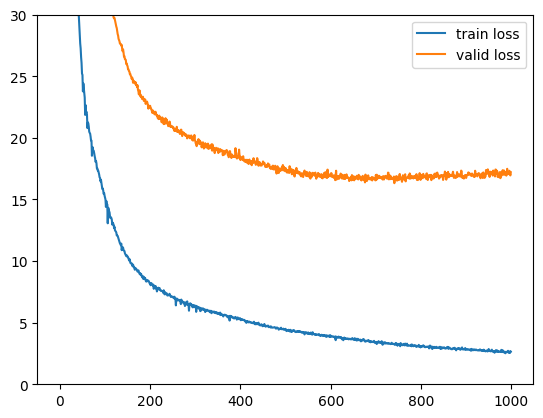

In [ ]:
# epoch 별 loss 변화률 시각화
plt.plot(range(1000), train_loss_list, label="train loss")
plt.plot(range(1000), valid_loss_list, label="valid loss")
plt.ylim(0, 30)
plt.legend()
plt.show()

In [ ]:
############################
# 모델 저장 - 불러오기
############################
import os
# 코랩-구글드라이브에 저장.
os.makedirs('saved_model', exist_ok=True)

torch.save(boston_model, "saved_model/boston_model.pt")

NameError: name 'boston_model' is not defined

In [ ]:
# 불러오기
load_boston_model = torch.load("saved_model/boston_model.pt", weights_only=False)

In [ ]:
###############################
# 파라미터만 저장 - 불러오기
###############################
# state_dict를 조회
torch.save(boston_model.state_dict(), "saved_model/boston_state_dict.pt")

In [ ]:
load_sd = torch.load("saved_model/boston_state_dict.pt")
load_boston_model2 = BostonModel()
load_boston_model2.load_state_dict(load_sd)

In [ ]:
##########################
# 최종평가
##########################

test_loss = 0.0

with torch.no_grad():
  for X_test, y_test in test_loader:
    # device로 이동
    X_test, y_test = X_test.to(device), y_test.to(device)
    # 추론
    pred_test = boston_model(X_test) #load_boston_model, load_boston_model2 >> 총 3개의 모델을 바꿔가면서 결과값이 바뀌지 않으면 성공!
    # loss 계산
    loss_test = loss_fn(pred_test, y_test)
    test_loss += loss_test.item()

  test_loss /= len(test_loader)

print(test_loss)


In [ ]:
# 새로운 데이터를 추론
new_X, _ = trainset[:5]
load_boston_model.eval()
with torch.no_grad():
  new_y = load_boston_model(new_X)

In [ ]:
new_y

## 분류 (Classification)

### Fashion MNIST Dataset - **다중분류(Multi-Class Classification) 문제**

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋.
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

- **Feature**이미지는 28x28 크기이며 Gray scale이다.
- **Target**은 총 10개의 class로 구성되어 있으며 각 class의 class 이름은 다음과 같다.

| 레이블 | 클래스       |
|--------|--------------|
| 0      | T-shirt/top |
| 1      | Trousers    |
| 2      | Pullover    |
| 3      | Dress       |
| 4      | Coat        |
| 5      | Sandal      |
| 6      | Shirt       |
| 7      | Sneaker     |
| 8      | Bag         |
| 9      | Ankle boot  |

> #### 학습 도중 모델 저장
>
> - 학습 도중 가장 좋은 성능을 보이는 모델이 나올 수 있다.
> - 학습 도중 모델을 저장하는 방법
>   1. 각 에폭이 끝날 때 마다 모델을 저장한다.
>   2. 한 에폭 학습 후 성능 개선이 있으면 모델을 저장하여 가장 성능 좋은 모델만 저장되도록 한다.
>      - 최고 성능 점수(best score)와 현재 에폭의 성능을 비교하여, 성능이 개선되었을 경우 모델을 저장(덮어쓰기)한다.
>
> #### 조기 종료(Early Stopping)
>
> - 학습 도중 성능 개선이 나타나지 않으면, 중간에 학습을 종료하도록 구현한다.
> - 에폭 수를 충분히 길게 설정한 뒤, 특정 횟수 동안 성능 개선이 없으면 학습을 조기 종료하도록 구현한다.


In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [7]:
# Dataset loading
fmnist_trainset = datasets.FashionMNIST(
    root='data', train=True, download=True,
    transform=transforms.ToTensor() # pytorch의 모델은 tensor로 넣어야한다. 필로우이미지임 확인할땐 tensor로 바꾸면 안되겠지?

)

fmnist_testset = datasets.FashionMNIST(
    root='data', train=False, download=True,
    transform=transforms.ToTensor()
)

100.0%
100.0%
100.0%
100.0%


In [ ]:
fmnist_trainset[0] # 필로우이미지임을 확인

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [ ]:
idx = 0
fmnist_trainset[idx][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [ ]:
# trainset >>> trainset/validset으로 분리
fmnist_trainset, fmnist_validset = torch.utils.data.random_split(fmnist_trainset, [50000, 10000])

In [ ]:
len(fmnist_trainset), len(fmnist_validset), len(fmnist_testset)

(50000, 10000, 10000)

In [ ]:
fmnist_testset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
fmnist_testset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
# DataLoader

train_loader = torch.utils.data.DataLoader(fmnist_trainset, batch_size=200, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(fmnist_validset, batch_size=200)
test_loader = torch.utils.data.DataLoader(fmnist_testset, batch_size=200)

In [3]:
from typing_extensions import ParamSpecKwargs
# 모델 정의

class FMNISTModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.lr1 = nn.Linear(28*28, 512)
    self.lr2 = nn.Linear(512, 256)
    self.lr3 = nn.Linear(256, 128)
    self.lr4 = nn.Linear(128, 64)
    self.lr5 = nn.Linear(64, 10) # 출력 >> class개수로 출력되어야함
    self.relu = nn.ReLU() # ReLU 함수는 Linear간에 한번씩 호출되지만, 입력값 출력값이 항상 같으므로 이렇게 한번만 써주면된다.


  def forward(self, X):
    """
    X: 입력 tensor - shape: [batch_size, 1, 28, 28] # >> 맨 앞의 batch_size는 유지한채 1x28x28을 flatten 시켜야한다.
    """

    # 1. flatten -> 3차원 입력을 1차원으로 변환.
    # 0번축(배치사이즈)을 유지하고 1번축부터 flatten >> 아래처럼 start_dim 정하면 된다.
    # torch.flatten(X, start_dim=1)
    X = nn. Flatten()(X) # 윗줄처럼 써도되지만, 이렇게 쓰면 default가 1번축 이후를 flatten하므로 결과는 똑같다.

    X = self.lr1(X)
    X = self.relu(X)

    X = self.lr2(X)
    X = self.relu(X)

    X = self.lr3(X)
    X = self.relu(X)

    X = self.lr4(X)
    X = self.relu(X)

    out = self.lr5(X) # CrossEntropyLoss()를 사용할 것이기 때문에 >> Linear 출력결과를 그대로 반환. (Softmax를 적용 안함.)
    return out

In [4]:
# 모델 구조 확인
m = FMNISTModel()
m

FMNISTModel(
  (lr1): Linear(in_features=784, out_features=512, bias=True)
  (lr2): Linear(in_features=512, out_features=256, bias=True)
  (lr3): Linear(in_features=256, out_features=128, bias=True)
  (lr4): Linear(in_features=128, out_features=64, bias=True)
  (lr5): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
from torchinfo import summary
summary(m, (200,1,28,28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
FMNISTModel                              [200, 10]                 --
├─Linear: 1-1                            [200, 512]                401,920
├─ReLU: 1-2                              [200, 512]                --
├─Linear: 1-3                            [200, 256]                131,328
├─ReLU: 1-4                              [200, 256]                --
├─Linear: 1-5                            [200, 128]                32,896
├─ReLU: 1-6                              [200, 128]                --
├─Linear: 1-7                            [200, 64]                 8,256
├─ReLU: 1-8                              [200, 64]                 --
├─Linear: 1-9                            [200, 10]                 650
Total params: 575,050
Trainable params: 575,050
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.01
Input size (MB): 0.63
Forward/backward pass size (MB): 1.55
Params size (MB): 2.30
Estimated 

In [ ]:
# 학습

LR = 0.001
EPOCHS = 20

fmnist_model = FMNISTModel().to(device)
optimizer = torch.optim.Adam(fmnist_model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# 다중분류 loss: categorical crossentropy
## CrossEntropyLoss의 역할: 1. y정답을 one hot encoding
#                           2. pred 예측값에 softmax를 적용
#                           3. categorical crossentropy 계산

In [ ]:
# 학습

import time

train_loss_list = []
valid_loss_list =[]
valid_acc_list = []

s = time.time()

# 1. train 코드 작성
for epoch in range(EPOCHS):
  # 학습
  fmnist_model.train()
  train_loss = 0.0
  for X_train, y_train in train_loader:
    # device로 이동
    X_train, y_train = X_train.to(device), y_train.to(device)

    # 추론
    pred_train = fmnist_model(X_train)

    # loss 계산
    loss = loss_fn(pred_train, y_train)

    # gradient 계산
    loss.backward()

    # parameter 업데이트
    optimizer.step()

    # gradient 초기화
    optimizer.zero_grad()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  train_loss_list.append(train_loss)

  # 1 epoch에 대한 검증
  fmnist_model.eval()
  valid_loss = valid_acc = 0.0
  with torch.no_grad():
    for X_valid, y_valid in valid_loader:
      # device로 이동
      X_valid, y_valid = X_valid.to(device), y_valid.to(device)

      # 추론
      pred_valid = fmnist_model(X_valid)

      # 검증
      ## loss
      valid_loss += loss_fn(pred_valid, y_valid).item()
      ## 정확도
      ### 모델이 예측한 정답 class -> 10개 출력값 중 가장 큰 값이 있는 index
      pred_class = pred_valid.argmax(dim=-1)
      valid_acc += torch.sum(pred_class == y_valid).item()
    valid_loss /= len(valid_loader) # step수로 나워서 평균계산
    valid_acc /= len(fmnist_validset) # 총 데이터 개수
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)


    print(f"[{epoch+1}/{EPOCHS}] train loss: {train_loss}, valid loss: {valid_loss}, valid acc: {valid_acc}")


e = time.time()
print(f'학습에 걸린 총 시간: {e-s}초')

[1/20] train loss: 0.6926234450340271, valid loss: 0.46827545583248137, valid acc: 0.8342
[2/20] train loss: 0.4203315385580063, valid loss: 0.37745515644550326, valid acc: 0.8657
[3/20] train loss: 0.3646973155140877, valid loss: 0.3468776512145996, valid acc: 0.8734
[4/20] train loss: 0.3326733750700951, valid loss: 0.3325105321407318, valid acc: 0.8788
[5/20] train loss: 0.3149102640748024, valid loss: 0.3231155779957771, valid acc: 0.8815
[6/20] train loss: 0.29440599924325944, valid loss: 0.31177900403738024, valid acc: 0.8862
[7/20] train loss: 0.27928076845407485, valid loss: 0.30516473680734635, valid acc: 0.8895
[8/20] train loss: 0.2701260127425194, valid loss: 0.3265059623122215, valid acc: 0.8801
[9/20] train loss: 0.2542883202433586, valid loss: 0.3065723532438278, valid acc: 0.8896
[10/20] train loss: 0.2463765830397606, valid loss: 0.304460289478302, valid acc: 0.8931
[11/20] train loss: 0.23688648909330368, valid loss: 0.2937082889676094, valid acc: 0.8923
[12/20] train

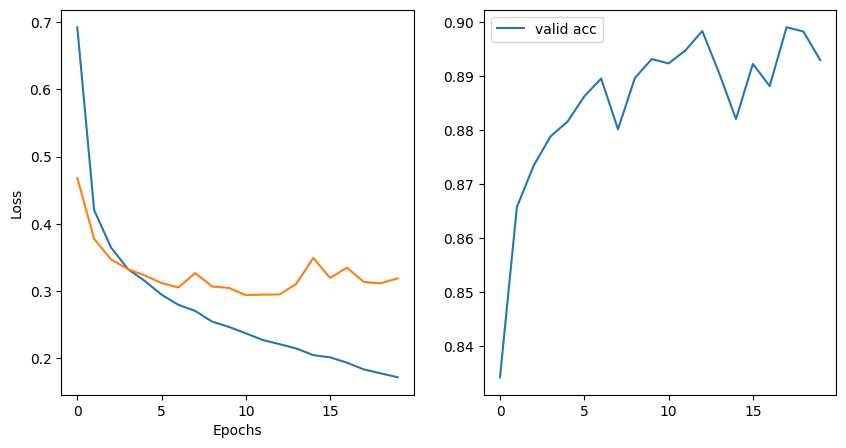

In [ ]:
# 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), train_loss_list, label="train loss")
plt.plot(range(EPOCHS), valid_loss_list, label="valid loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), valid_acc_list, label="valid acc")

plt.legend()
plt.show()

In [ ]:
import numpy as np
np.min(valid_loss_list), np.argmin(valid_loss_list)
#>>> 10 epoch때 성능이 가장 좋은 것 확인
#>>> 10 이후는 불필요 epoch >> early stopping을 하는 이유
#>>> 이하 early stopping 반영한 coding

(np.float64(0.2937082889676094), np.int64(10))

In [ ]:
# 학습

import time

train_loss_list = []
valid_loss_list =[]
valid_acc_list = []

#################################
# 1. 학습 도중 이전 epoch들 보다 성능이 개선되면 모델을 저장
# 2. 특정 epoch 동안 성능 개선이 없으면 학습을 중지
#################################
# 변수들 선언
saved_path = "saved_models/fashion_mnist_model.pt" # 성능이 좋으면 이전 모델 위에 덮어 씌움
best_score = torch.inf # 현재 가장 좋은 평가지표(loss)
# best_score > 검증loss : 성능이 개선됐다는 의미 -> 모델을 저장함

## 조기종료 관련 변수
patience = 5 # 성능이 개선되는지 안되는지를 가리기 위해 몇 에폭을 기다릴지 지정
trigger_cnt = 0 # 몇 에폭째 기다리는지 저장할 변수

EPOCHS = 100 # 조기종료할 것이므로, 충분한 횟수를 넣는다.

s = time.time()

# 1. train 코드 작성
for epoch in range(EPOCHS):
  # 학습
  fmnist_model.train()
  train_loss = 0.0
  for X_train, y_train in train_loader:
    # device로 이동
    X_train, y_train = X_train.to(device), y_train.to(device)

    # 추론
    pred_train = fmnist_model(X_train)

    # loss 계산
    loss = loss_fn(pred_train, y_train)

    # gradient 계산
    loss.backward()

    # parameter 업데이트
    optimizer.step()

    # gradient 초기화
    optimizer.zero_grad()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  train_loss_list.append(train_loss)

  # 1 epoch에 대한 검증
  fmnist_model.eval()
  valid_loss = valid_acc = 0.0
  with torch.no_grad():
    for X_valid, y_valid in valid_loader:
      # device로 이동
      X_valid, y_valid = X_valid.to(device), y_valid.to(device)

      # 추론
      pred_valid = fmnist_model(X_valid)

      # 검증
      ## loss
      valid_loss += loss_fn(pred_valid, y_valid).item()
      ## 정확도
      ### 모델이 예측한 정답 class -> 10개 출력값 중 가장 큰 값이 있는 index
      pred_class = pred_valid.argmax(dim=-1)
      valid_acc += torch.sum(pred_class == y_valid).item()
    valid_loss /= len(valid_loader) # step수로 나워서 평균계산
    valid_acc /= len(fmnist_validset) # 총 데이터 개수
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)


    print(f"[{epoch+1}/{EPOCHS}] train loss: {train_loss}, valid loss: {valid_loss}, valid acc: {valid_acc}")

  # 1 epoch 학습/검증 종료 후 모델 저장(성능개선 시), 조기 종료(성능개선이 없을 시)
  if valid_loss < best_score: # 이전 epoch의 결과보다 성능 개선됨.
    # 모델 저장
    torch.save(fmnist_model, saved_path)
    best_score = valid_loss
    print(f">>>>>>>>>{epoch+1} 에폭에서 저장. {best_score}에서 {valid_loss}만큼 validation loss가 개선됨")
    trigger_cnt = 0 # 조기 종료를 위해서 성능개선을 기다리는 에폭 수. 위에서 성능이 개선됐으므로, 기다리는 횟수를 초기화해야한다.
  else:
    # 조기종료 처리
    trigger_cnt += 1
    if patience == trigger_cnt: # 조건문: 기다리겠다고한 횟수만큼 성능개선이 없다면,
      print(f"==========={epoch+1} 에폭에서 조기종료합니다. {best_score}에서 개선되지 않음")
      break

e = time.time()
print(f'학습에 걸린 총 시간: {e-s}초')

[1/100] train loss: 0.6967282490730285, valid loss: 0.5465206801891327, valid acc: 0.8042
>>>>>>>>>1 에폭에서 저장. 0.5465206801891327에서 0.5465206801891327만큼 validation loss가 개선됨
[2/100] train loss: 0.4151137247085571, valid loss: 0.4063951528072357, valid acc: 0.849
>>>>>>>>>2 에폭에서 저장. 0.4063951528072357에서 0.4063951528072357만큼 validation loss가 개선됨
[3/100] train loss: 0.35968864339590073, valid loss: 0.36774504482746123, valid acc: 0.8646
>>>>>>>>>3 에폭에서 저장. 0.36774504482746123에서 0.36774504482746123만큼 validation loss가 개선됨
[4/100] train loss: 0.3352346517443657, valid loss: 0.3604216593503952, valid acc: 0.8665
>>>>>>>>>4 에폭에서 저장. 0.3604216593503952에서 0.3604216593503952만큼 validation loss가 개선됨
[5/100] train loss: 0.3093026876449585, valid loss: 0.33425917774438857, valid acc: 0.8752
>>>>>>>>>5 에폭에서 저장. 0.33425917774438857에서 0.33425917774438857만큼 validation loss가 개선됨
[6/100] train loss: 0.290894495844841, valid loss: 0.32237122833728793, valid acc: 0.8789
>>>>>>>>>6 에폭에서 저장. 0.32237122833728793

In [ ]:
# 최종평가

with torch.no_grad():
  test_loss = 0.0
  test_acc =0.0
  for X_test, y_test in test_loader:
    # device로 이동
    X_test, y_test = X_test.to(device), y_test.to(device)
    pred_test = fmnist_model(X_test)
    loss_test = loss_fn(pred_test, y_test)
    test_loss += loss_test.item()
    test_acc += torch.sum(pred_test.argmax(dim=-1) == y_test).item()
  test_loss /= len(test_loader)
  test_acc /= len(fmnist_testset)
print(test_loss, test_acc)


0.36659312188625337 0.8825


In [5]:
load_fmodel = torch.load("fashion_mnist_model.pt", weights_only=False)
load_fmodel

FMNISTModel(
  (lr1): Linear(in_features=784, out_features=512, bias=True)
  (lr2): Linear(in_features=512, out_features=256, bias=True)
  (lr3): Linear(in_features=256, out_features=128, bias=True)
  (lr4): Linear(in_features=128, out_features=64, bias=True)
  (lr5): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [13]:
dataloader = torch.utils.data.DataLoader(fmnist_testset, batch_size=50)
x, y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

In [ ]:
with torch.no_grad():
    pred_logit = load_fmodel(x)
    result = torch.max(pred_logit, dim = -1) 

In [ ]:
print(result.values) #>> 1번축 방향 별로(가로방향) logit의 max값과 max의 index를 보여줌.

tensor([ 6.6165, 10.2547, 17.5566, 15.8298,  5.5867, 12.9642, 12.3320, 12.8852,
        12.3735,  7.2927,  5.8394,  8.4934,  5.0595,  6.3468,  5.9614,  9.6942,
         8.1569,  6.4463, 11.1379,  5.2048,  3.2624,  4.3939,  7.9788,  5.0826,
        16.5399,  5.5271,  7.8283,  4.4728,  5.8460,  2.2570, 18.4551, 14.1004,
         4.2600,  3.6490, 22.8172,  8.0234,  6.0692,  9.5096,  7.7339, 10.2880,
         6.9833, 14.9835,  5.2897,  5.6794,  8.4235,  5.0249,  3.5945,  8.6214,
         5.4602,  4.6217])


In [19]:
print("확률값으로 변환 - softmax")
pred_proba = nn.Softmax(dim=-1)(pred_logit)
print(pred_proba)

확률값으로 변환 - softmax
tensor([[2.1240e-05, 1.3741e-07, 2.1774e-08, 1.3933e-07, 5.7134e-07, 5.3490e-03,
         9.4112e-07, 4.0693e-03, 3.0450e-06, 9.9056e-01],
        [7.7839e-05, 8.9436e-09, 9.9583e-01, 1.6291e-06, 2.2422e-03, 1.9047e-13,
         1.8472e-03, 4.1912e-14, 1.4444e-07, 3.2516e-14],
        [7.1783e-11, 1.0000e+00, 1.9656e-13, 1.3607e-10, 1.3024e-14, 5.8065e-18,
         3.2179e-10, 1.4075e-21, 2.1389e-13, 8.0509e-16],
        [4.9369e-10, 1.0000e+00, 3.1878e-12, 3.9710e-09, 2.1329e-13, 8.4467e-17,
         1.1058e-09, 2.0288e-20, 1.5356e-12, 5.8884e-15],
        [2.2420e-01, 8.2326e-06, 1.1056e-03, 6.8042e-04, 3.6434e-04, 4.2179e-05,
         7.7358e-01, 1.4358e-08, 1.3949e-05, 5.8992e-08],
        [7.3029e-08, 1.0000e+00, 8.7635e-10, 2.0184e-08, 6.9003e-11, 3.8155e-13,
         2.0961e-07, 4.9910e-16, 3.4739e-10, 7.3725e-12],
        [1.7963e-08, 1.9673e-09, 8.7838e-05, 8.1959e-07, 9.9958e-01, 4.0402e-13,
         3.2866e-04, 9.6261e-13, 2.6871e-10, 3.9642e-13],
        

In [20]:
result = torch.max(pred_proba, dim=-1)
result

torch.return_types.max(
values=tensor([0.9906, 0.9958, 1.0000, 1.0000, 0.7736, 1.0000, 0.9996, 0.9994, 1.0000,
        0.9984, 0.9165, 0.9999, 0.5519, 0.9979, 0.8424, 1.0000, 0.9948, 0.8746,
        1.0000, 0.9471, 0.7399, 0.6761, 0.9997, 0.9855, 1.0000, 0.7187, 0.9264,
        0.8197, 0.9780, 0.4040, 1.0000, 1.0000, 0.9744, 0.8790, 1.0000, 0.9943,
        0.9982, 0.9999, 0.9995, 0.9999, 0.9350, 1.0000, 0.8963, 0.9547, 0.9171,
        0.9510, 0.7934, 0.9999, 0.4417, 0.8384]),
indices=tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 2, 8, 0, 2, 5, 7, 5,
        1, 2, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 7, 6, 7, 2, 1,
        2, 6]))

In [24]:
def predict(model, x):
    with torch.no_grad():
        pred = model(x)
        pred_proba = nn.Softmax(dim=-1)(pred)
        result = torch.max(pred_proba, dim=-1)
        return [(idx.item(), proba.item()) for idx, proba in zip(result.indices, result.values)]

In [25]:
result = predict(load_fmodel, x)

In [26]:
result

[(9, 0.9905555844306946),
 (2, 0.9958310723304749),
 (1, 1.0),
 (1, 1.0),
 (6, 0.7735845446586609),
 (1, 0.9999996423721313),
 (4, 0.9995827078819275),
 (6, 0.9994454979896545),
 (5, 0.9999996423721313),
 (7, 0.9984103441238403),
 (4, 0.9164848923683167),
 (5, 0.9999071359634399),
 (7, 0.5518661737442017),
 (3, 0.9979277849197388),
 (4, 0.8423774838447571),
 (1, 0.9999840259552002),
 (2, 0.994787335395813),
 (2, 0.8745715022087097),
 (8, 0.9999815225601196),
 (0, 0.9470783472061157),
 (2, 0.7399144768714905),
 (5, 0.6761211156845093),
 (7, 0.9997068047523499),
 (5, 0.9854647517204285),
 (1, 1.0),
 (2, 0.7186679840087891),
 (6, 0.9263898134231567),
 (0, 0.819709300994873),
 (9, 0.9779600501060486),
 (3, 0.4039537310600281),
 (8, 1.0),
 (8, 0.9999992847442627),
 (3, 0.9743779897689819),
 (3, 0.8789570927619934),
 (8, 1.0),
 (0, 0.9943010807037354),
 (7, 0.9981901049613953),
 (5, 0.9999299049377441),
 (7, 0.9994679093360901),
 (9, 0.9998764991760254),
 (0, 0.9349932670593262),
 (1, 1.0),


### 위스콘신 유방암 데이터셋 - **이진분류(Binary Classification) 문제**

-   **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현
        - output layer: units=1, activation='sigmoid'
        - loss: binary_crossentropy
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer: units=2, activation='softmax', y(정답)은 one hot encoding 처리
        - loss: categorical_crossentropy
-   위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
-   Feature
    -   종양에 대한 다양한 측정값들
-   Target의 class
    -   0 - malignant(악성종양)
    -   1 - benign(양성종양)


In [34]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [35]:
# Dataset
X, y = load_breast_cancer(return_X_y=True)
y = y.reshape(-1, 1) #>>> 최초의 y.shape은 (569,)이다. 이걸 2차원으로 (569,1)로 만들어야한다.
# X.shape, y.shape, X.dtype
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

In [36]:
# 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# class name <-> class index
classes = np.array(["악성종양", "양성종양"])
class_to_idx = {"악성종양":0, "양성종양":1}

In [38]:
# Dataset
## 모델의 weight, bias -> float32. X, y는 weight, bias와 계산을 하게 되기 때문에 타입을 맞춰준다.
trainset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
testset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

In [39]:
trainset.classes = classes
trainset.class_to_idx = class_to_idx

In [40]:
# DataLoader
train_loader = DataLoader(trainset, batch_size=200, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=100)

In [41]:
X_train.shape #>>> 1번축이 30 이므로, lr1은 30으로 시작해야한다.

(426, 30)

In [42]:
######### 모델 정의
class BreastCancerModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(30, 32)
        self.lr2 = nn.Linear(32, 8)
        self.lr3 = nn.Linear(8, 1) # 출력 Layer 처리하는 함수. out_features=1 : positive일 확률.
        self.relu = nn.ReLU()
        self.logistic = nn.Sigmoid() # 입력값을 0 ~ 1 사이 실수로 반환.

    def forward(self, X):
        X = self.lr1(X)
        X = self.relu(X)
        X = self.lr2(X)
        X = self.relu(X)
        # 출력 Layer
        output = self.lr3(X)
        output = self.logistic(output)
        return output

In [43]:
b_model = BreastCancerModel()
b_model

BreastCancerModel(
  (lr1): Linear(in_features=30, out_features=32, bias=True)
  (lr2): Linear(in_features=32, out_features=8, bias=True)
  (lr3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (logistic): Sigmoid()
)

In [ ]:
# %pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [44]:
from torchinfo import summary
summary(b_model, (10, 30), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BreastCancerModel                        [10, 1]                   --
├─Linear: 1-1                            [10, 32]                  992
├─ReLU: 1-2                              [10, 32]                  --
├─Linear: 1-3                            [10, 8]                   264
├─ReLU: 1-4                              [10, 8]                   --
├─Linear: 1-5                            [10, 1]                   9
├─Sigmoid: 1-6                           [10, 1]                   --
Total params: 1,265
Trainable params: 1,265
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [45]:
# dummy data로 출력
dummy_x = torch.randn(10, 30)
# dummy_x.shape
result = b_model(dummy_x)
# result.shape
result

tensor([[0.5550],
        [0.5214],
        [0.5718],
        [0.5858],
        [0.5482],
        [0.5564],
        [0.5696],
        [0.5312],
        [0.5634],
        [0.5519]], grad_fn=<SigmoidBackward0>)

In [46]:
(result > 0.5).type(torch.int32)  # bool -> int (True: 1, False: 0)

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)

In [47]:
lr = 0.001
epochs = 1000
######## 학습(train)
b_model = b_model.to(device)
optimizer = optim.Adam(b_model.parameters(), lr=lr)
loss_fn = nn.BCELoss()   # 함수이름: binary crossentropy

In [48]:
import time

### 모델 학습(train) 로직 작성
#### 검증 결과 -> train loss, valid_loss, valid_accuracy
### 모델 성능이 개선될 때 마다 저장.
### 조기종료 - 10 epoch 동안 성능 개선이 없으면 조기종료

save_path = "saved_models/bc_model.pt"
best_score = torch.inf   # validation loss 기준으로 저장/조기종료 여부 확인.
patience = 10
trigger_cnt = 0

train_losses, valid_losses, valid_acces = [], [], []

s = time.time()
for epoch in range(epochs):
    ################### train #######################
    b_model.train()
    train_loss = 0.0
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        pred = b_model(X_train)  # positive일 확률
        loss = loss_fn(pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    ################### validation ##################
    b_model.eval()
    valid_loss = valid_acc = 0.0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            pred_test = b_model(X_test) # positive일 확률
            valid_loss += loss_fn(pred_test, y_test).item()
            #  이진 분류에서 accuracy
            valid_acc += torch.sum((pred_test > 0.5).type(torch.int32) == y_test).item()
        valid_loss /= len(test_loader)
        valid_acc /= len(test_loader.dataset)
        valid_losses.append(valid_loss)
        valid_acces.append(valid_acc)

    log_template = "[{:04d}/{}] train loss: {}, valid loss: {}, valid accuracy: {}"
    print(log_template.format(epoch+1, epochs, train_loss, valid_loss, valid_acc))
    # 모델 저장, 조기종료
    if valid_loss <  best_score: # 성능 개선
        print(f">>>>>> {epoch+1}에서 성능이 개선되어 저장합니다. {valid_loss}")
        torch.save(b_model, save_path)
        best_score = valid_loss
        trigger_cnt = 0
    else:
        trigger_cnt += 1
        if patience == trigger_cnt:
            print(f"{epoch+1} 에폭에서 조기종료 합니다. {best_score}에서 개선되지 않음.")
            break

e = time.time()
print("걸린시간(초):", e-s)

[0001/1000] train loss: 0.6767658889293671, valid loss: 0.6614393293857574, valid accuracy: 0.6293706293706294
>>>>>> 1에서 성능이 개선되어 저장합니다. 0.6614393293857574
[0002/1000] train loss: 0.6646051108837128, valid loss: 0.6521230936050415, valid accuracy: 0.6293706293706294
>>>>>> 2에서 성능이 개선되어 저장합니다. 0.6521230936050415
[0003/1000] train loss: 0.6562506556510925, valid loss: 0.643548458814621, valid accuracy: 0.6293706293706294
>>>>>> 3에서 성능이 개선되어 저장합니다. 0.643548458814621
[0004/1000] train loss: 0.6441288888454437, valid loss: 0.6349571645259857, valid accuracy: 0.6293706293706294
>>>>>> 4에서 성능이 개선되어 저장합니다. 0.6349571645259857
[0005/1000] train loss: 0.6399944424629211, valid loss: 0.6261858642101288, valid accuracy: 0.6293706293706294
>>>>>> 5에서 성능이 개선되어 저장합니다. 0.6261858642101288
[0006/1000] train loss: 0.628075897693634, valid loss: 0.6172932684421539, valid accuracy: 0.6293706293706294
>>>>>> 6에서 성능이 개선되어 저장합니다. 0.6172932684421539
[0007/1000] train loss: 0.6200313568115234, valid loss: 0.608

<function matplotlib.pyplot.show(close=None, block=None)>

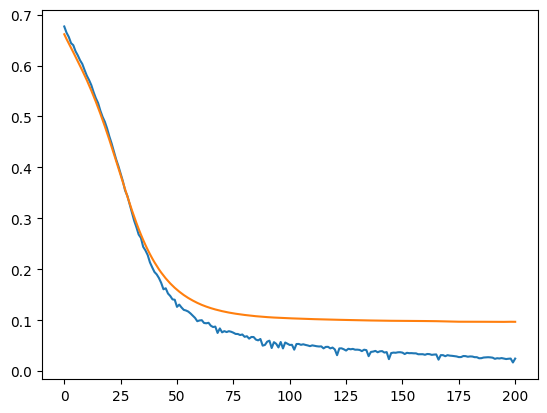

In [49]:
## loss, acc 시각화

plt.plot(range(len(train_losses)), train_losses, label='train_loss')
plt.plot(range(len(valid_losses)), valid_losses, label='valid loss')
plt.legend
plt.show

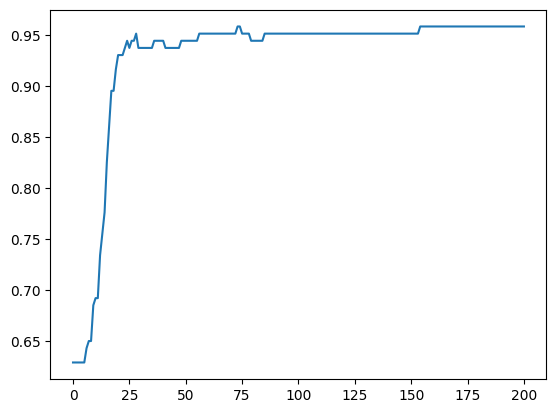

In [50]:
plt.plot(range(len(valid_acces)), valid_acces)
plt.show()

In [51]:
best_model = torch.load(save_path, weights_only=False)
best_model

BreastCancerModel(
  (lr1): Linear(in_features=30, out_features=32, bias=True)
  (lr2): Linear(in_features=32, out_features=8, bias=True)
  (lr3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (logistic): Sigmoid()
)

In [ ]:
def predict_bc(model, X, device="cpu"):
    # model로 X를 추론한 결과를 반환
    # label, 확률
    result = []
    with torch.no_grad():
        pred_proba = model(X)
        pred_class = (pred_proba > 0.5).type(torch.int32)
        for class_index, proba in zip(pred_class, pred_proba):
            # print(class_index, proba if class_index.item() == 1 else 1-proba)
            result.append((class_index.item(), proba if class_index.item() == 1 else 1-proba))
            # proba는 양성일 확률. 모델이 예측한 class가 1이면 proba를 그대로 쓰고, 모델이 예측한 class가 0 이면 1-proba를 써야한다.
        return result

In [56]:
new_data = torch.tensor(X_test_scaled[:5], dtype=torch.float32)
# print(new_data.shape)
result = predict_bc(best_model, new_data, device)

In [57]:
result

[(1, tensor([0.9985])),
 (0, tensor([0.9999])),
 (0, tensor([0.9985])),
 (1, tensor([0.9998])),
 (0, tensor([0.9944]))]

# 모델 유형별 구현 정리

## 공통

-   Input layer(첫번째 Layer)의 in_features
    -   입력데이터의 feature(속성) 개수에 맞춰준다.
-   Hidden layer 수
    -   경험적(art)으로 정한다.
    -   Hidden layer에 Linear를 사용하는 경우 보통 feature 수를 줄여 나간다. (핵심 특성들을 추출해나가는 과정의 개념.)

## 회귀 모델

-   output layer의 출력 unit개수(out_features)
    -   정답의 개수
    -   ex
        -   집값: 1
        -   아파트가격, 단독가격, 빌라가격: 3 => y의 개수에 맞춘다.
-   출력 Layer에 적용하는 activation 함수
    -   일반적으로 **None**
    -   값의 범위가 설정되 있고 그 범위의 값을 출력하는 함수가 있을 경우
        -   ex) 0 ~ 1: logistic(Sigmoid), -1 ~ 1: hyperbolic tangent(Tanh)
-   loss함수
    -   MSELoss
-   평가지표
    -   MSE, RMSE, R square($R^2$)

## 다중분류 모델

-   output layer의 unit 개수
    -   정답 class(고유값)의 개수
-   출력 Layer에 적용하는 activation 함수
    -   Softmax: 클래스별 확률을 출력
-   loss함수
    -   **categrocial crossentropy**
    -   파이토치 함수
        -   **CrossEntropyLoss** = NLLLoss(정답) + LogSoftmax(모델 예측값)
        -   **NLLLoss**
            -   정답을 OneHot Encoding 처리 후 Loss를 계산한다.
            -   입력으로 LogSoftmax 처리한 모델 예측값과 onehot encoding 안 된 정답을 받는다.
        -   **LogSoftmax**
            -   입력값에 Softmax 계산후 그 Log를 계산한다.
                -   NLLLoss의 모델 예측값 입력값으로 처리할 때 사용한다.

```python
pred = model(input)
loss1 = nn.NLLLoss(nn.LogSoftmax(dim=-1)(pred), y)
# or
loss2 = nn.CrossEntropyLoss()(pred, y)
```

## 이진분류 모델

-   output layer의 unit 개수
    -   1개 (positive일 확률)
-   출력 Layer에 적용하는 activation 함수
    -   Sigmoid(Logistic)
-   loss 함수
    -   **Binary crossentropy**
    -   파이토치 함수: **BCELoss**
